In [1]:
import json
import os
import time
import torch
import torch.utils.data
import torch.optim as optim
from torchvision import transforms
from my_dataset import MyDataSet
from utils import split_data, create_lr_scheduler, get_params_groups, train_one_epoch, evaluate
import numpy as np

/home/lorenzo/miniconda3/envs/rfdet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = 'cuda:0'
data_path = "../2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"
snr_range = [-20, 30]
snr_step = 2
batch_size = 16
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
num_classes = 24
model = "convnext"
if model == 'convnext':
    from model import convnext as create_model
elif model == "convnet":
    from models.convnet import ConvNet as create_model

In [6]:
acc = {}
device = torch.device(device if torch.cuda.is_available() else "cpu")
print(f"using {device} device...")
for snr in range(snr_range[0], snr_range[1]+1, snr_step):
    
    print(f"Validating for snr {snr} dB")
    
    # create model
    net = create_model(num_classes=num_classes).to(device)
    # load model weights
    model_weight_path = f"./weights/{model}/snr{snr}.pth"
    net.load_state_dict(torch.load(model_weight_path, map_location=device))

    data_dir = os.path.dirname(os.path.abspath(data_path))
    # train_indexes, train_labels, val_indexes, val_labels
    reload_data = True
    if os.path.exists(data_dir + '/train_indexes.json') and not reload_data:
        with open(data_dir + '/val_indexes.json') as f:
            val_indexes = json.load(f)
        with open(data_dir + '/val_label.json') as f:
            val_labels = json.load(f)
    else:
        train_indexes, train_labels, val_indexes, val_labels = split_data(data_path, snr,
                                                                          ratio=[0.875, 0.125, 0.],
                                                                          test=False, one_hot=False)

    print("using valid data size: {}".format(len(val_labels)))
    data_transform = {
        "val": transforms.Compose([transforms.ToTensor()])
    }

    val_dataset = MyDataSet(hdf5_path=data_path,
                            mod_class=val_labels,
                            indexes=val_indexes,
                            model=model,
                            transform=data_transform["val"])
    
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=nw)
    
    # validate
    val_loss, val_acc = evaluate(model=net,
                                 data_loader=val_loader,
                                 device=device,
                                 epoch=1)
    acc[snr] = val_acc

using cuda:0 device...
Validating for snr -20 dB
using valid data size: 12288
[valid epoch 1] loss: 3.184, acc: 0.043: 100%|██████████| 768/768 [00:05<00:00, 145.69it/s]
Validating for snr -18 dB
using valid data size: 12288
[valid epoch 1] loss: 4.588, acc: 0.044: 100%|██████████| 768/768 [00:05<00:00, 142.55it/s]
Validating for snr -16 dB
using valid data size: 12288
[valid epoch 1] loss: 3.647, acc: 0.043: 100%|██████████| 768/768 [00:05<00:00, 147.50it/s]
Validating for snr -14 dB
using valid data size: 12288
[valid epoch 1] loss: 3.447, acc: 0.047: 100%|██████████| 768/768 [00:05<00:00, 147.05it/s]
Validating for snr -12 dB
using valid data size: 12288
[valid epoch 1] loss: 2.833, acc: 0.110: 100%|██████████| 768/768 [00:05<00:00, 146.26it/s]
Validating for snr -10 dB
using valid data size: 12288
[valid epoch 1] loss: 2.462, acc: 0.153: 100%|██████████| 768/768 [00:05<00:00, 142.93it/s]
Validating for snr -8 dB
using valid data size: 12288
[valid epoch 1] loss: 2.298, acc: 0.187: 

In [9]:
import json
import matplotlib.pyplot as plt

In [10]:
with open("accuracy_convnet.json", "w") as f:
    json.dump(acc_convnet, f, indent=6)

In [11]:
with open("accuracy_convnext.json", "w") as f:
    json.dump(acc_convnext, f, indent=6)

Text(0.5, 1.0, 'ConvNext vs ConvNet Accuracies')

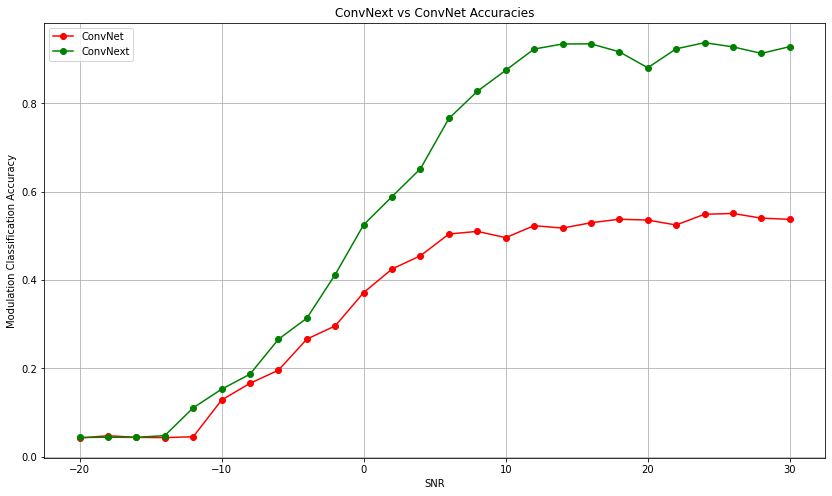

In [14]:
plt.figure(figsize=(14, 8))
plt.grid()
plt.ylabel("Modulation Classification Accuracy")
plt.xlabel("SNR")
plt.plot(acc_convnet.keys(), acc_convnet.values(), '-ro', label="ConvNet")
plt.plot(acc_convnext.keys(), acc_convnext.values(), '-go', label="ConvNext")
plt.legend()
plt.title("ConvNext vs ConvNet Accuracies")